In [1]:
SEED = 123456
import os
import random as rn
import numpy as np
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

import time 
start_time = time.time()

from varname import nameof
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input

from keras import optimizers
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

from keras.models import Sequential, Model 
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import History 

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

import tensorflow as tf
tf.random.set_seed(1234)
print(tf.__version__)

plt.style.use('ggplot')

%matplotlib inline
print("--- %s seconds ---" % (time.time() - start_time))


2.3.0
--- 2.6055185794830322 seconds ---


In [2]:
## Define Variables

main_folder = 'data_/'
images_folder = main_folder + 'images/'
TRAINING_SAMPLES = 200
VALIDATION_SAMPLES = 30
TEST_SAMPLES = 30
# IMG_WIDTH = 32
# IMG_HEIGHT = 32
BATCH_SIZE = 4
NUM_EPOCHS = 20

In [3]:
## Read Data 

df_attr = pd.read_csv(main_folder + 'data.csv')
print(df_attr.shape)
# df_attr.head()

## Rename images for read 

for i in df_attr["images"]:
    df_attr["images"][i]= "{}.png".format(i)
    
# df_attr

(277, 3)


<ipython-input-3-b9a2d997663b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_attr["images"][i]= "{}.png".format(i)


In [4]:
## Generate (Train, Val & Test)

def load_reshape_img(fname):
    img = load_img(fname,target_size=(IMG_WIDTH,IMG_HEIGHT))
    x = img_to_array(img)/255.
    x = x.reshape( x.shape)
    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_attr[(df_attr['partition'] == partition) 
                           & (df_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_attr[(df_attr['partition'] == partition) 
                                  & (df_attr[attr] == 1)].sample(int(num_samples/2),replace=True)])
    
    # for Train and Validation
    if partition != 2:
        x_ = np.asarray([load_reshape_img(images_folder + fname) for fname in df_["images"]])
        y_ = np_utils.to_categorical(df_[attr],2)
        
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread('{}{}.png'.format(images_folder, index))
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

In [5]:
## LeNet5 NN 

LeNet5_model = Sequential()
LeNet5_model.add(Conv2D(filters=6, kernel_size=(5,5), padding='same', activation='relu', input_shape=(32, 32, 3)))
LeNet5_model.add(MaxPool2D(pool_size=(2, 2)))
LeNet5_model.add(Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='relu'))
LeNet5_model.add(MaxPool2D(pool_size=(2, 2)))
LeNet5_model.add(Flatten())
LeNet5_model.add(Dense(120, activation='relu'))
LeNet5_model.add(Dense(84, activation='relu'))
LeNet5_model.add(Dense(2, activation='softmax'))

## ALexNet NN

ALexNet_model = Sequential()
ALexNet_model.add(Conv2D(filters=96, kernel_size=(11,11),strides = (4,4), padding='same', activation='relu', input_shape=(227, 227, 3)))
ALexNet_model.add(MaxPool2D(pool_size=(3, 2)))
ALexNet_model.add(tf.keras.layers.ZeroPadding2D(padding=(2, 2)))
ALexNet_model.add(Conv2D(filters=256, kernel_size=(5,5), padding= 'valid', activation='relu'))
ALexNet_model.add(MaxPool2D(pool_size=(3, 2)))
ALexNet_model.add(tf.keras.layers.ZeroPadding2D(padding=(1, 1)))
ALexNet_model.add(Conv2D(filters=384, kernel_size=(3,3), padding= 'valid', activation='relu'))
ALexNet_model.add(tf.keras.layers.ZeroPadding2D(padding=(1, 1)))
ALexNet_model.add(Conv2D(filters=384, kernel_size=(3,3), padding= 'valid', activation='relu'))
ALexNet_model.add(tf.keras.layers.ZeroPadding2D(padding=(1, 1)))
ALexNet_model.add(Conv2D(filters=256, kernel_size=(3,3), padding= 'valid', activation='relu'))
ALexNet_model.add(MaxPool2D(pool_size=(3, 2)))
ALexNet_model.add(Flatten())
ALexNet_model.add(Dense(4096, activation='relu'))
ALexNet_model.add(Dense(4096, activation='relu'))
ALexNet_model.add(Dense(2, activation='softmax'))

Model 0 Training For 2 Epocs...................... 


Size of Training input images :(200, 32, 32, 3)
Size of Training outpur images :(200, 2)

Size of Validation input images :(30, 32, 32, 3)
Size of Validation outpur images :(30, 2)

Size of Testing input images :30
Size of Testing outpur images :30



Epoch 00001: val_accuracy improved from -inf to 0.66667, saving model to model_0_file_path_2_Epocs.hdf5.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_0_file_path_2_Epocs.hdf5.\assets

Epoch 00002: val_accuracy improved from 0.66667 to 0.86667, saving model to model_0_file_path_2_Epocs.hdf5.
INFO:tensorflow:Assets written to: model_0_file_path_2_Epocs.hdf5.\assets


----------------------------------------------------------------------------

Ploting Loss Funct

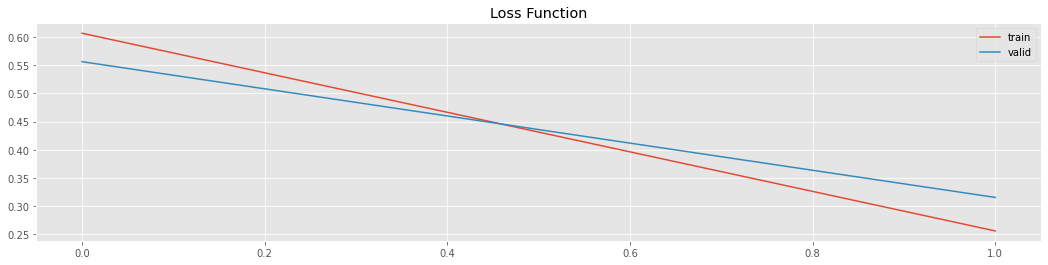



----------------------------------------------------------------------------
----------------------------------------------------------------------------
Training Fished ..............



Testing Process Start  ..............

Test Report 
-------------- 
Model Evaluation.....
Test accuracy: 100.0000%
f1_score: 1.0
Confusion Matrix For Test 
--------------------------- 
[[15  0]
 [ 0 15]]
-------------- 
Test Report 
-------------- 
              precision    recall  f1-score   support

        Down       1.00      1.00      1.00        15
      Normal       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

----------------------------------------------------------------------- 


************************************************************************
************************************************************************
*************

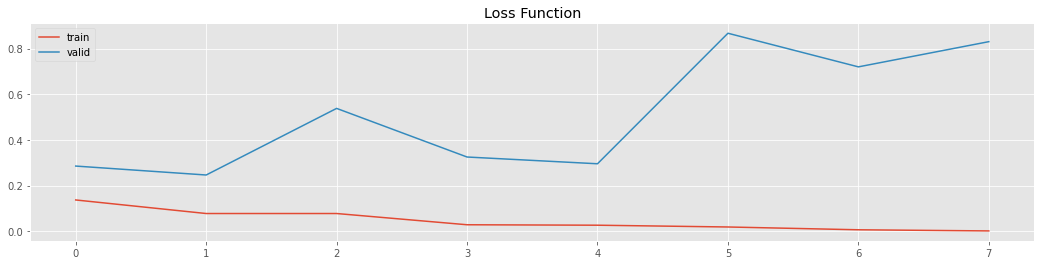



----------------------------------------------------------------------------
----------------------------------------------------------------------------
Training Fished ..............



Testing Process Start  ..............

Test Report 
-------------- 
Model Evaluation.....
Test accuracy: 100.0000%
f1_score: 1.0
Confusion Matrix For Test 
--------------------------- 
[[15  0]
 [ 0 15]]
-------------- 
Test Report 
-------------- 
              precision    recall  f1-score   support

        Down       1.00      1.00      1.00        15
      Normal       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

----------------------------------------------------------------------- 


************************************************************************
************************************************************************
*************

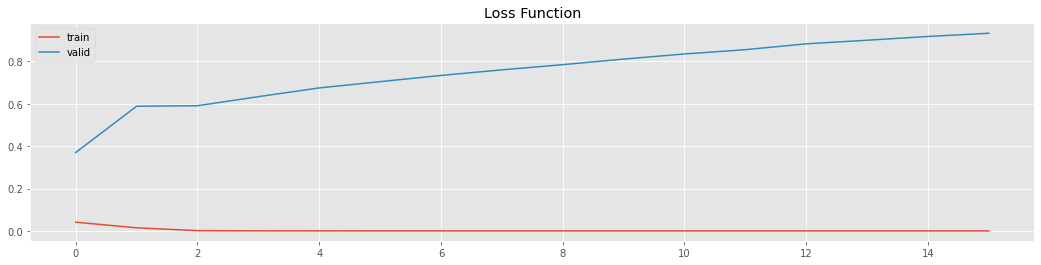



----------------------------------------------------------------------------
----------------------------------------------------------------------------
Training Fished ..............



Testing Process Start  ..............

Test Report 
-------------- 
Model Evaluation.....
Test accuracy: 100.0000%
f1_score: 1.0
Confusion Matrix For Test 
--------------------------- 
[[15  0]
 [ 0 15]]
-------------- 
Test Report 
-------------- 
              precision    recall  f1-score   support

        Down       1.00      1.00      1.00        15
      Normal       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

----------------------------------------------------------------------- 


************************************************************************
************************************************************************
*************

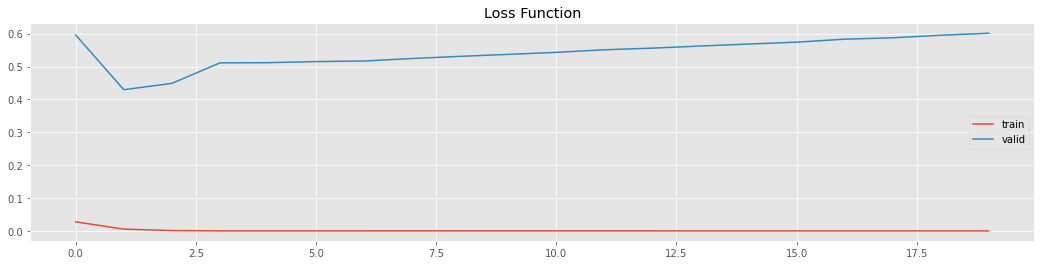



----------------------------------------------------------------------------
----------------------------------------------------------------------------
Training Fished ..............



Testing Process Start  ..............

Test Report 
-------------- 
Model Evaluation.....
Test accuracy: 100.0000%
f1_score: 1.0
Confusion Matrix For Test 
--------------------------- 
[[15  0]
 [ 0 15]]
-------------- 
Test Report 
-------------- 
              precision    recall  f1-score   support

        Down       1.00      1.00      1.00        15
      Normal       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

----------------------------------------------------------------------- 


************************************************************************
************************************************************************
*************

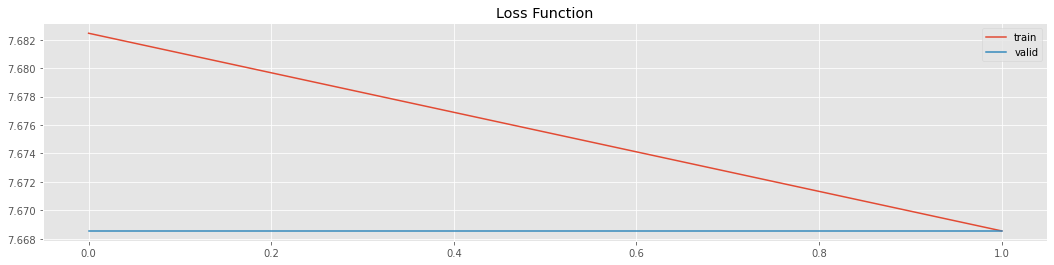



----------------------------------------------------------------------------
----------------------------------------------------------------------------
Training Fished ..............



Testing Process Start  ..............

Test Report 
-------------- 
Model Evaluation.....
Test accuracy: 50.0000%
f1_score: 0.6666666666666666
Confusion Matrix For Test 
--------------------------- 
[[ 0 15]
 [ 0 15]]
-------------- 
Test Report 
-------------- 
              precision    recall  f1-score   support

        Down       0.00      0.00      0.00        15
      Normal       0.50      1.00      0.67        15

    accuracy                           0.50        30
   macro avg       0.25      0.50      0.33        30
weighted avg       0.25      0.50      0.33        30

----------------------------------------------------------------------- 


************************************************************************
************************************************************************

C:\Users\AG\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AG\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AG\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Size of Training input images :(200, 227, 227, 3)
Size of Training outpur images :(200, 2)

Size of Validation input images :(30, 227, 227, 3)
Size of Validation outpur images :(30, 2)

Size of Testing input images :30
Size of Testing outpur images :30



Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to model_1_file_path_8_Epocs.hdf5.
INFO:tensorflow:Assets written to: model_1_file_path_8_Epocs.hdf5.\assets

Epoch 00002: val_accuracy did not improve from 0.50000

Epoch 00003: val_accuracy did not improve from 0.50000

Epoch 00004: val_accuracy did not improve from 0.50000

Epoch 00005: val_accuracy did not improve from 0.50000

Epoch 00006: val_accuracy did not improve from 0.50000

Epoch 00007: val_accuracy did not improve from 0.50000

Epoch 00008: val_accuracy did not improve from 0.50000


----------------------------------------------------------------------------

Ploting Loss Function..............



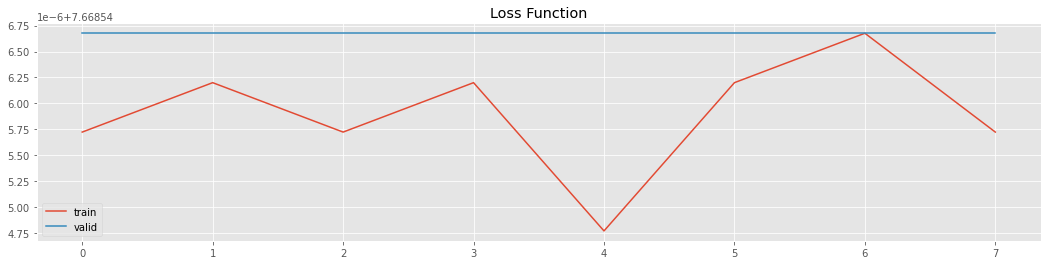



----------------------------------------------------------------------------
----------------------------------------------------------------------------
Training Fished ..............



Testing Process Start  ..............

Test Report 
-------------- 
Model Evaluation.....
Test accuracy: 50.0000%
f1_score: 0.6666666666666666
Confusion Matrix For Test 
--------------------------- 
[[ 0 15]
 [ 0 15]]
-------------- 
Test Report 
-------------- 
              precision    recall  f1-score   support

        Down       0.00      0.00      0.00        15
      Normal       0.50      1.00      0.67        15

    accuracy                           0.50        30
   macro avg       0.25      0.50      0.33        30
weighted avg       0.25      0.50      0.33        30

----------------------------------------------------------------------- 


************************************************************************
************************************************************************

C:\Users\AG\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AG\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AG\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Size of Training input images :(200, 227, 227, 3)
Size of Training outpur images :(200, 2)

Size of Validation input images :(30, 227, 227, 3)
Size of Validation outpur images :(30, 2)

Size of Testing input images :30
Size of Testing outpur images :30



Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to model_1_file_path_16_Epocs.hdf5.
INFO:tensorflow:Assets written to: model_1_file_path_16_Epocs.hdf5.\assets

Epoch 00002: val_accuracy did not improve from 0.50000

Epoch 00003: val_accuracy did not improve from 0.50000

Epoch 00004: val_accuracy did not improve from 0.50000

Epoch 00005: val_accuracy did not improve from 0.50000

Epoch 00006: val_accuracy did not improve from 0.50000

Epoch 00007: val_accuracy did not improve from 0.50000

Epoch 00008: val_accuracy did not improve from 0.50000

Epoch 00009: val_accuracy did not improve from 0.50000

Epoch 00010: val_accuracy did not improve from 0.50000

Epoch 00011: val_accuracy did not improve from 0.50000

Ep

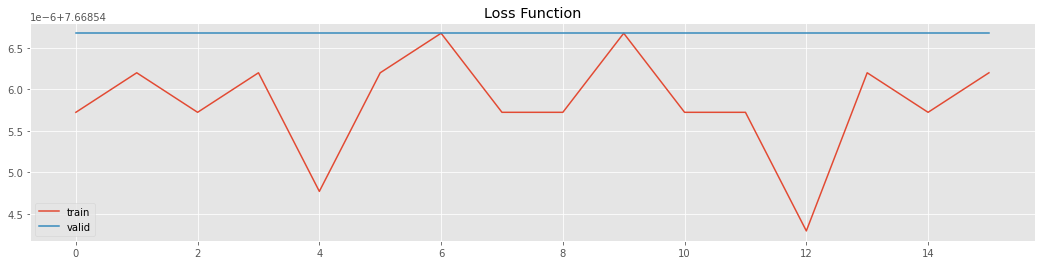



----------------------------------------------------------------------------
----------------------------------------------------------------------------
Training Fished ..............



Testing Process Start  ..............

Test Report 
-------------- 
Model Evaluation.....
Test accuracy: 50.0000%
f1_score: 0.6666666666666666
Confusion Matrix For Test 
--------------------------- 
[[ 0 15]
 [ 0 15]]
-------------- 
Test Report 
-------------- 
              precision    recall  f1-score   support

        Down       0.00      0.00      0.00        15
      Normal       0.50      1.00      0.67        15

    accuracy                           0.50        30
   macro avg       0.25      0.50      0.33        30
weighted avg       0.25      0.50      0.33        30

----------------------------------------------------------------------- 


************************************************************************
************************************************************************

C:\Users\AG\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AG\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AG\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Size of Training input images :(200, 227, 227, 3)
Size of Training outpur images :(200, 2)

Size of Validation input images :(30, 227, 227, 3)
Size of Validation outpur images :(30, 2)

Size of Testing input images :30
Size of Testing outpur images :30



Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to model_1_file_path_20_Epocs.hdf5.
INFO:tensorflow:Assets written to: model_1_file_path_20_Epocs.hdf5.\assets

Epoch 00002: val_accuracy did not improve from 0.50000

Epoch 00003: val_accuracy did not improve from 0.50000

Epoch 00004: val_accuracy did not improve from 0.50000


KeyboardInterrupt: 

In [6]:
model_image_size = [[32,32],[227,227]] 
models = [LeNet5_model , ALexNet_model]
Epocs = [2,8,16,20]

for i in range(2):
    for epoc_num in Epocs:
        print("Model {} Training For {} Epocs...................... \n\n".format(i,epoc_num))
        ## 1- Maintain Data
        IMG_WIDTH , IMG_HEIGHT = model_image_size[i]
        x_train, y_train = generate_df(0, 'normal', TRAINING_SAMPLES)
        print("Size of Training input images :{}".format(x_train.shape))
        print("Size of Training outpur images :{}\n".format(y_train.shape))
        x_valid, y_valid = generate_df(1, 'normal', VALIDATION_SAMPLES)
        print("Size of Validation input images :{}".format(x_valid.shape))
        print("Size of Validation outpur images :{}\n".format(y_valid.shape))
        x_test, y_test = generate_df(2, 'normal', TEST_SAMPLES)
        print("Size of Testing input images :{}".format(len(x_test)))
        print("Size of Testing outpur images :{}\n\n".format(len(y_test)))

        ## 2- Train
        model = models[i]
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        filepath="model_{}_file_path_{}_Epocs.hdf5.".format(i,epoc_num)
        checkpointer = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
        hist = model.fit(x_train,y_train
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= epoc_num
                      , callbacks=[checkpointer]
                      , verbose=0
                    )
        print("\n\n----------------------------------------------------------------------------")
        print("\nPloting Loss Function..............\n")
        plt.figure(figsize=(18, 4))
        plt.plot(hist.history['loss'], label = 'train')
        plt.plot(hist.history['val_loss'], label = 'valid')
        plt.legend()
        plt.title('Loss Function')
        plt.show()
        print("\n\n----------------------------------------------------------------------------")
        print("----------------------------------------------------------------------------")
        print("Training Fished ..............\n\n\n")

        ## 3- Test Process
        print("Testing Process Start  ..............\n")
        model_predictions = [np.argmax(model.predict(feature)) for feature in x_test ]
        test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)

        print("Test Report ")
        print("-------------- ")
        print('Model Evaluation.....')
        print('Test accuracy: %.4f%%' % test_accuracy)
        print('f1_score:', f1_score(y_test, model_predictions))
        print("Confusion Matrix For Test ")
        print("--------------------------- ")
        print(confusion_matrix(y_test, model_predictions))
        print("-------------- ")
        print("Test Report ")
        print("-------------- ")
        print(classification_report(y_test, model_predictions, target_names=("Down","Normal")))
        print("----------------------------------------------------------------------- ")

        print("\n\n************************************************************************")
        print("************************************************************************")
        print("************************************************************************\n\n")